<a href="https://colab.research.google.com/github/piotrkobierski7/FAIpriv/blob/main/Roofs_LoadingItems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Power on

In [ ]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [ ]:
#hide
from fastbook import *
from fastai.vision.widgets import *

##Azure key

In [ ]:
import os
key = os.environ.get('AZURE_SEARCH_KEY', '4aea9372c5134982bc78e932aac76bb6')

In [ ]:
search_images_bing

<function fastbook.search_images_bing>

## Testing

In [ ]:
results = search_images_bing(key, 'roof tile')
ims = results.attrgot('contentUrl')
len(ims)

150

In [ ]:
ims = ['https://roof-dach.pl/wp-content/uploads/2021/01/slajd3.png']

In [ ]:
dest = 'images/roof.jpg'
download_url(ims[0], dest)

Path('images/roof.jpg')

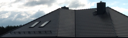

In [ ]:
im = Image.open(dest)
im.to_thumb(128,128)

##Getting pictures of roofs

In [ ]:
roof_types = 'architectural shingles','tile','metal '
path = Path('roofs')

In [ ]:
if not path.exists():
    path.mkdir()
    for o in roof_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} roof')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [ ]:
fns = get_image_files(path)
fns

(#441) [Path('roofs/tile/00000133.jpg'),Path('roofs/tile/00000023.jpg'),Path('roofs/tile/00000050.jpg'),Path('roofs/tile/00000105.jpg'),Path('roofs/tile/00000080.jpg'),Path('roofs/tile/00000017.jpg'),Path('roofs/tile/00000056.jpg'),Path('roofs/tile/00000132.jpg'),Path('roofs/tile/00000122.jpg'),Path('roofs/tile/00000040.jpg')...]

In [ ]:
failed = verify_images(fns)
failed

(#0) []

In [ ]:
failed.map(Path.unlink);

In [ ]:
#im = Image.open('roofs/slate/00000102.jpg')
#im.to_thumb(128,128)

FileNotFoundError: ignored

## From Data to DataLoaders

In [ ]:
roofs = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(1024))

In [ ]:
dls = roofs.dataloaders(path)

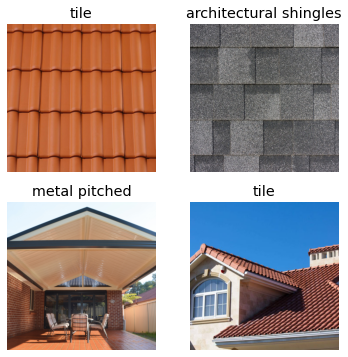

In [ ]:
dls.valid.show_batch(max_n=4, nrows=2)

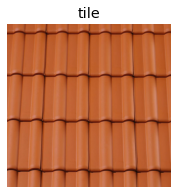

In [ ]:
roofs = roofs.new(item_tfms=Resize(1024, ResizeMethod.Squish))
dls = roofs.dataloaders(path)
dls.valid.show_batch(max_n=1, nrows=1)

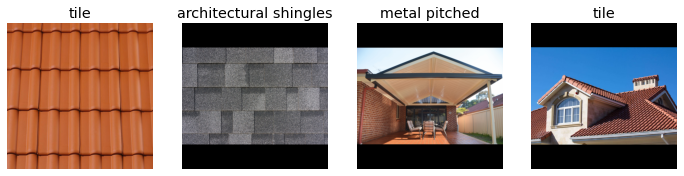

In [ ]:
roofs = roofs.new(item_tfms=Resize(1024, ResizeMethod.Pad, pad_mode='zeros'))
dls = roofs.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

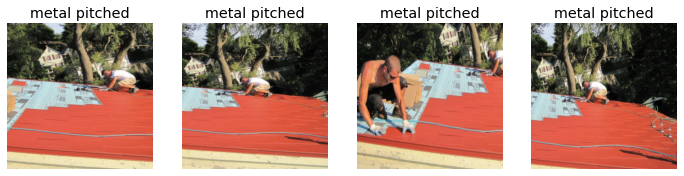

In [ ]:
roofs = roofs.new(item_tfms=RandomResizedCrop(1024, min_scale=0.3))
dls = roofs.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

## Training Your Model, and Using It to Clean Your Data

In [ ]:
roofs = roofs.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = roofs.dataloaders(path)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch,train_loss,valid_loss,error_rate,time
0,1.342930,1.260414,0.284091,00:19


epoch,train_loss,valid_loss,error_rate,time
0,0.762284,0.579314,0.215909,00:19
1,0.633631,0.660037,0.181818,00:20
2,0.503465,0.758500,0.204545,00:19
3,0.431743,0.757466,0.204545,00:19


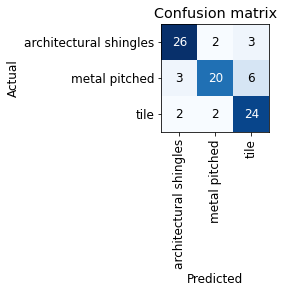

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

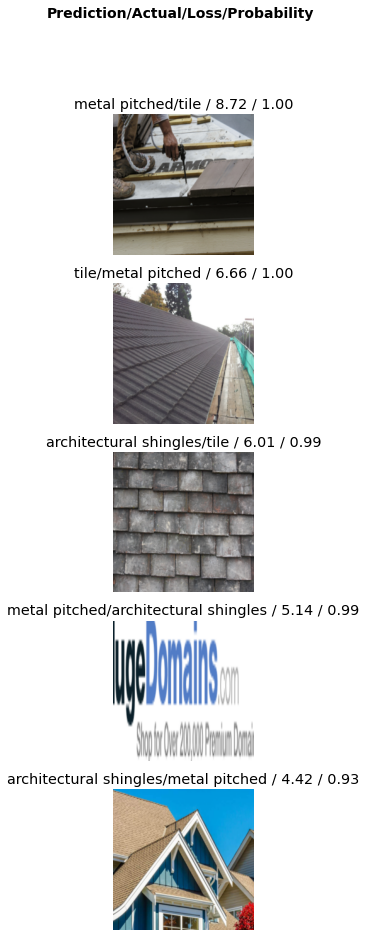

In [ ]:
interp.plot_top_losses(5, nrows=5)

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

FileNotFoundError: ignored

In [ ]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Turning Your Model into an Online Application

### Using the Model for Inference

In [ ]:
learn.export()

In [ ]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [ ]:
learn_inf = load_learner(path/'export.pkl')

In [ ]:
learn_inf.predict('images/roof.jpg')

('tile', tensor(2), tensor([0.0019, 0.0088, 0.9894]))

In [ ]:
learn_inf.dls.vocab

['architectural shingles', 'metal pitched', 'tile']

### Creating a Notebook App from the Model

In [ ]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [ ]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['images/roof.jpg'])

In [ ]:
img = PILImage.create(btn_upload.data[-1])

In [ ]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [ ]:
pred,pred_idx,probs = learn_inf.predict(img)

In [ ]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: tile; Probability: 0.9894')

In [ ]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [ ]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [ ]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [ ]:
VBox([widgets.Label('Select your roof!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

### Turning Your Notebook into a Real App

In [ ]:
#hide
!pip install voila
!jupyter serverextension enable --sys-prefix voila 

     |████████████████████████████████| 1.6 MB 5.3 MB/s 
     |████████████████████████████████| 393 kB 39.5 MB/s 
     |████████████████████████████████| 112 kB 56.3 MB/s 
     |████████████████████████████████| 551 kB 44.8 MB/s 
     |████████████████████████████████| 77 kB 7.0 MB/s 
     |████████████████████████████████| 52 kB 1.3 MB/s 
     |████████████████████████████████| 428 kB 47.5 MB/s 
  Attempting uninstall: tornado
    Found existing installation: tornado 5.1.1
    Uninstalling tornado-5.1.1:
      Successfully uninstalled tornado-5.1.1
  Attempting uninstall: jupyter-client
    Found existing installation: jupyter-client 5.3.5
    Uninstalling jupyter-client-5.3.5:
      Successfully uninstalled jupyter-client-5.3.5
  Attempting uninstall: nbconvert
    Found existing installation: nbconvert 5.6.1
    Uninstalling nbconvert-5.6.1:
      Successfully uninstalled nbconvert-5.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are

Enabling: voila
- Writing config: /usr/etc/jupyter
    - Validating...
Error loading server extension voila
      X is voila importable?
